# CDJ Project Social Security

The purpose of this file is to show labor participation rates of youth, alongside college enrollment rates. 

Data from: LaborForceParticipation/data_20_24.csv (find link) and https://ourworldindata.org/grapher/population-by-age-group?country=~USA and https://educationdata.org/college-enrollment-statistics

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import requests

In [4]:
#Extract labor participation data

path_16_19 = "../data/data_16_19.csv" #dataset path
path_20_24 = "../data/data_20_24.csv" #dataset path

data_16_19 = pd.read_csv(path_16_19) #extract data
data_20_24 = pd.read_csv(path_20_24) #extract data

data_16_19.rename(columns={'LNS11300036': 'Participation_16_19'}, inplace= True)
data_20_24.rename(columns={'LNS11300012': 'Participation_20_24'}, inplace=True)

data_16_19['DATE'] = pd.to_datetime(data_16_19['DATE']) #convert to dt
data_20_24['DATE'] = pd.to_datetime(data_20_24['DATE']) #convert to dt

merge_data = pd.merge(data_16_19, data_20_24, on= 'DATE') #merge

filtered_data = merge_data[ (merge_data['DATE'].dt.year >= 1948) & (merge_data['DATE'].dt.year <= 2024)] #filter years

years = filtered_data['DATE'] #years column in dt format
participation_16_19 = filtered_data['Participation_16_19'] #data pts 
participation_20_24 = filtered_data['Participation_20_24'] #data pts

# Calculate 12-month moving averages
filtered_data['MA_16_19'] = filtered_data['Participation_16_19'].rolling(window=12).mean() #create new col with 12 month moving average data pts
filtered_data['MA_20_24'] = filtered_data['Participation_20_24'].rolling(window=12).mean()

In [6]:
#https://ourworldindata.org/grapher/population-by-age-group?country=~USA 

# Fetch the data from ourworldindata. The User-Agent header is only necessary on google colab.
df_young = pd.read_csv("https://ourworldindata.org/grapher/population-by-age-group.csv?v=1&csvType=filtered&useColumnShortNames=true&country=~USA", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Fetch the metadata
metadata = requests.get("https://ourworldindata.org/grapher/population-by-age-group.metadata.json?v=1&csvType=filtered&useColumnShortNames=true&country=~USA").json()


df_young.drop(columns= ["Entity",
                  "Code",
                  "population__sex_all__age_65plus__variant_estimates.1",
                 "population__sex_all__age_25_64__variant_estimates.1",
                 "population__sex_all__age_15_24__variant_estimates.1",
                 "population__sex_all__age_5_14__variant_estimates.1",
                 "population__sex_all__age_0_4__variant_estimates.1"], inplace = True) #drop useless columns
df_young = df_young[["Year","population__sex_all__age_15_24__variant_estimates"]].set_index(["Year"]) #set index as year


df_college = pd.read_excel("../data/College_Enrollment_data.xlsx") #import college enrollment data
df_college = df_college[["Year", "Total Enrollment"]].set_index(["Year"]) #set index as year


merged_df_outer = pd.merge(df_young, df_college, left_index=True, right_index=True, how='outer') #merge df_young and df_college
merged_df_outer["College Rates"] = merged_df_outer["Total Enrollment"]/merged_df_outer["population__sex_all__age_15_24__variant_estimates"] #get proportion

In [7]:
filtered_data.reset_index().set_index(["DATE"], inplace = True) #labor participation data frame from above. Set Index as year
merged_df_outer.reset_index(inplace = True) # Reset Index (yes...what i'm doing is inefficient)
filtered_data.reset_index(inplace = True) # Reset Index (yes...what i'm doing is inefficient)
merged_df_outer["Year"] = pd.to_datetime(merged_df_outer['Year'].astype(str) + '-01-01') # create datetime column of years (yes...what i'm doing is inefficient)

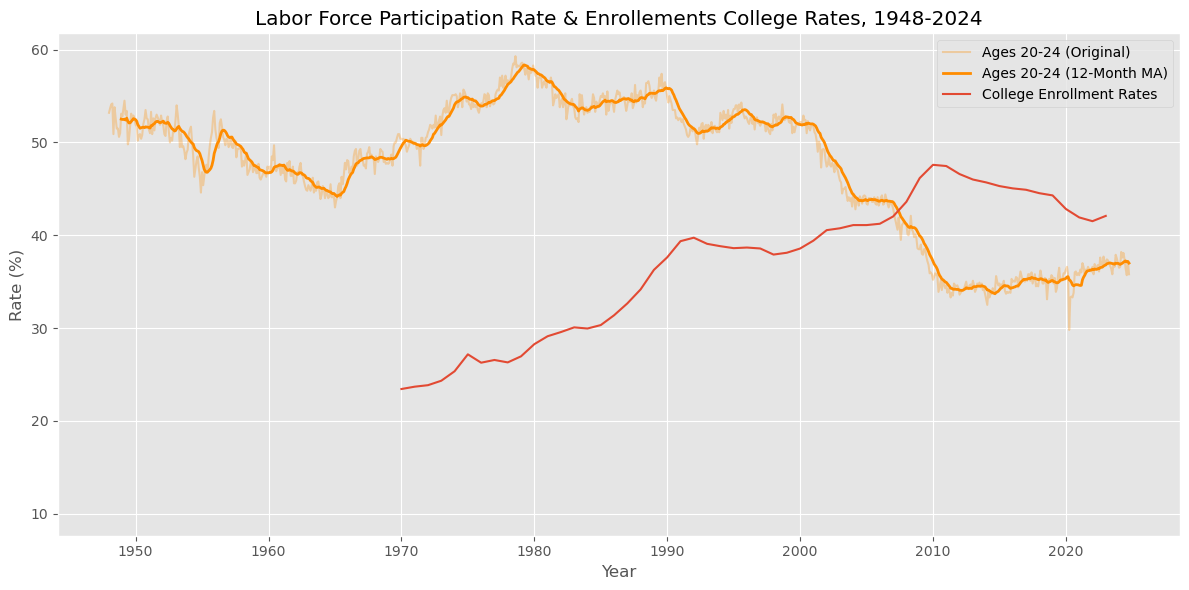

In [10]:
filtered_data['MA_20_24'] = filtered_data['Participation_20_24'].rolling(window=12).mean() #get 12 month average moving average

plt.style.use('ggplot') # set style
plt.figure(figsize = (12,6)) # set figsize

plt.plot(years, participation_20_24, color='darkorange', alpha=0.3, label='Ages 20-24 (Original)') #plot original
plt.plot(filtered_data['DATE'], filtered_data['MA_20_24'], color='darkorange', linewidth=2, label='Ages 20-24 (12-Month MA)') #plot moving average
plt.plot(merged_df_outer["Year"], merged_df_outer["College Rates"]*100, label = "College Enrollment Rates") # plot college enrollment rates

# Add title and labels
plt.title('Labor Force Participation Rate & Enrollements College Rates, 1948-2024')
plt.xlabel('Year')
plt.ylabel('Rate (%)')

plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()
